# Q1

Assume that there is a politician. They begin a year with an approval rating of $z_1$. Then, each day, their popularity randomly goes up or down following a random walk of Gaussian noise with a standard deviation of $\sigma^\text{trans}$ ("Transition noise").

$$
 \begin{align} z_t & \sim \mathrm{normal}(50,  \sigma^\text{trans}), \quad t=1 \\ z_t & \sim \mathrm{normal}(z_{t-1}, \sigma^\text{trans}), \quad t > 1 \ \end{align} 
$$

This produces a sequence of true popularity values $z₁, z₂, \cdots, z_{365}$.

In addition, on each day, voters are polled on their approval for the candidate. The measured approval  $x_t$ is the true approval plus Gaussian noise with a standard deviation of $\sigma^\text{obs}$. ("Observation noise".)

$$
\begin{align} x_t & \sim \mathrm{normal}(z_t, \sigma^\text{obs}) \end{align}
$$

Write down Pangolin code for a joint model of $z_1, \cdots, z_{365}$ and $x_1, \cdots, x_{365}$. Include your code directly in your solution. (For this question, you should only report your model code, nothing else.) Use no imports other than `pangolin`.

For this question, you should assume that $\sigma^\text{trans}=0.125$ and $\sigma^\text{obs}=1$.

Notes:

- Technically, in this model, it is possible that $x_t$ or $z_t$ could be less than zero. While this would not be possible in the real world, we will ignore this issue for simplicity.



In [72]:
import pangolin as pg

sig_trans = 0.125
sig_obs = 1

z = pg.slot()
x = pg.slot()
z_1 = pg.slot()

T = 365

z_fn = pg.autoregressive(lambda last: pg.normal(last, sig_trans), 365)
z = z_fn(50)

with pg.Loop(365) as t:
    x[t] = pg.normal(z[t], sig_obs)


# Q2

The file `polls1.npz` contains 2 arrays. The first array, `t`, contains 100 integers between 0 and 364, indicating 100 days out of the year (0-indexed). The second array, `x_t` contains observed polling data $x_t$ on each of those days. Do inference to get samples for the value of $z$ given that $x_t$ is equal to the given value for each time $t$ included in `polls1.npz`. Store your samples in an array `z_samples`. (This should be an array of size 10,000 × 365.)

You might find the following command useful for reading in the data. (You may only use numpy for reading in data.)

```python
# numpy allowed only for reading in data!
import numpy as np
data = np.load('polls1.npz')
observed_times = data['t']
x_obs = data['x_t']

```

Note:

- You are free to re-use your code from the previous question, but make sure your answer to this question is self-contained.
- Be careful! Note that not all days $x_t$ are observed.
- For your answer, you should include your full self-contained code to calculate `z_samples`, and nothing else.
- Do not use any imports other than `pangolin`. (Except for using numpy to read in the data.)



In [73]:
# numpy allowed only for reading in data!
import numpy as np
import pangolin as pg


data = np.load('polls1.npz')
observed_times = data['t']
x_obs = data['x_t']

# observations can not be rv
observed_times_pg = pg.makerv(observed_times)

sig_trans = pg.makerv(0.125)
sig_obs = pg.makerv(1)

z = pg.slot()
x = pg.slot()

# API for autoregressive
# self-refernece (recusion)
z = pg.autoregressive(lambda last: pg.normal(last, sig_trans), 365)(50.0)


with pg.Loop(100) as i:
    x[i] = pg.normal(z[observed_times_pg[i]], sig_obs)


z_samples = pg.sample(z, x, x_obs, niter=10000) # ?
print(z_samples.shape)

NONE
NONE
NONE
NONE
NONE
NONE
NONE
(10000, 365)


# Q3

Finally, plot the mean and 95% posterior interval for the true candidate approval for each day, on top of the given data. You can do this using the following code, assuming you have loaded `t` from `polls1.npz` into the variable `observed_times` and `x_t` from `polls1.npz` into the variable `x_obs`.

```python
from matplotlib import pyplot as plt
plt.plot(observed_times,x_obs,'k.',label='observed polls')
plt.fill_between(np.arange(365),
                 np.percentile(z_samples,5,axis=0),
                 np.percentile(z_samples,95,axis=0),
                 color='blue',
                 alpha=0.5,
                 label='posterior 95% interval')
plt.plot(z_samples.mean(0),'r-',label='true popularity')
plt.legend();

```

You only need to include your plot.



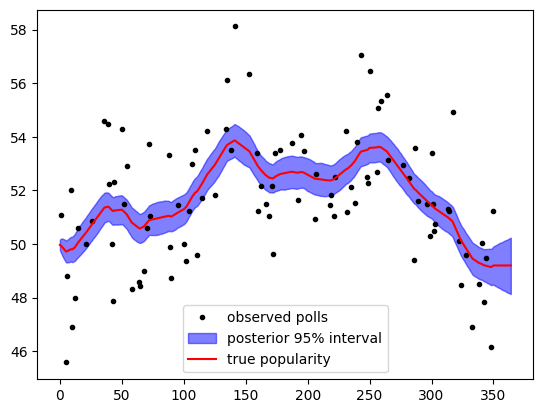

In [74]:
from matplotlib import pyplot as plt

plt.plot(observed_times,x_obs,'k.',label='observed polls')
plt.fill_between(np.arange(365),
                 np.percentile(z_samples,5,axis=0),
                 np.percentile(z_samples,95,axis=0),
                 color='blue',
                 alpha=0.5,
                 label='posterior 95% interval')
plt.plot(z_samples.mean(0),'r-',label='true popularity')
plt.legend();

# Q4

In this question, you will implement a slightly more complex version of the model from Q2. Rather than assuming $\sigma^\text{trans}$ and $\sigma^\text{obs}$ are observed and known, we will now put a prior over them. Use the model:

$$
\begin{align} \sigma^\text{trans} & \sim \mathrm{exponential}(1) \\ \sigma^\text{obs} & \sim \mathrm{exponential}(1) \\ z_t & \sim \mathrm{normal}(50,  \sigma^\text{trans}), \quad t=1 \\ z_t & \sim \mathrm{normal}(z_{t-1}, \sigma^\text{trans}), \quad t > 1 \\ x_t & \sim \mathrm{normal}(z_t, \sigma^\text{obs}) \ \end{align} 
$$

Do inference to get samples for the values of $z$, $\sigma^\text{trans}$, and $\sigma^\text{obs}$ given that $x_t$ is equal to the given value for each time $t$ included in `polls1.npz`. Store your samples in an array `z_samples`. (This should be an array of size 10,000 × 365.)

Notes:

- For your answer, you should include your full self-contained code to calculate `z_samples`, and nothing else.
- Do not use any imports other than `pangolin`.



In [75]:
# numpy allowed only for reading in data!
import numpy as np
import pangolin as pg


data = np.load('polls1.npz')
observed_times = data['t']
x_obs = data['x_t']

# observations can not be rv
observed_times_pg = pg.makerv(observed_times)

sig_trans = pg.exponential(1)
sig_obs = pg.exponential(1)

z = pg.slot()
x = pg.slot()

# API for autoregressive
# self-refernece (recusion)
z = pg.autoregressive(lambda last: pg.normal(last, sig_trans), 365)(50.0)


with pg.Loop(100) as i:
    x[i] = pg.normal(z[observed_times_pg[i]], sig_obs)


z_samples = pg.sample(z, x, x_obs, niter=10000) # ?
print(z_samples.shape)

NONE
NONE
NONE
NONE
NONE
NONE
NONE
(10000, 365)


# Q5

Create histograms for samples of $\sigma^\text{trans}$ and $\sigma^\text{obs}$ given the observed $x_t$. (Use `bins=100` and `density=True`). Show the resulting histograms only (you may plot them in the same figure if it’s visible).



In [76]:
sig_trans_samples = pg.sample(sig_trans, x, x_obs, niter=1000)
sig_obs_samples = pg.sample(sig_obs, x, x_obs, niter=1000)

NONE
NONE
NONE
NONE
NONE
NONE
NONE
NONE
NONE
NONE
NONE
NONE


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jason\AppData\Local\Temp\ipykernel_1164\4078426848.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Posterior Distributions of $\sigma^{trans}$ and $\sigma^{obs}$')
C:\Users\jason\AppData\Local\Temp\ipykernel_1164\4078426848.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


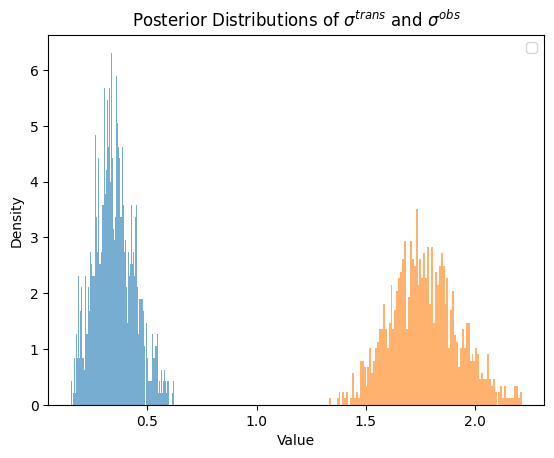

In [77]:
import matplotlib.pyplot as plt

# Histogram for σ^trans
plt.hist(sig_trans_samples, bins=100, density=True, alpha=0.6)

# Histogram for σ^obs
plt.hist(sig_obs_samples, bins=100, density=True, alpha=0.6)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior Distributions of $\sigma^{trans}$ and $\sigma^{obs}$')

# Add legend
plt.legend()

# Display the plot
plt.show()

# Q6

Create a plot for samples of $z$ given the observed $x_t$, similarly to the plot in Q3. Show your plot only.



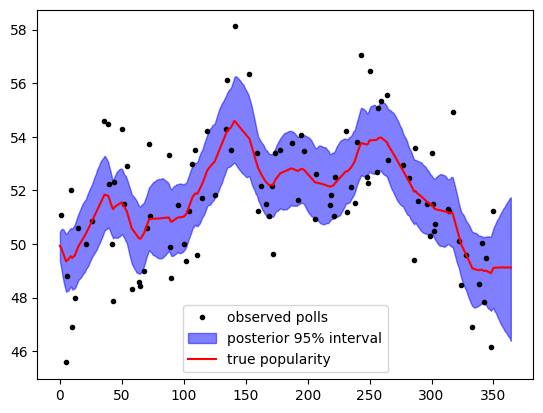

In [78]:
from matplotlib import pyplot as plt

plt.plot(observed_times,x_obs,'k.',label='observed polls')
plt.fill_between(np.arange(365),
                 np.percentile(z_samples,5,axis=0),
                 np.percentile(z_samples,95,axis=0),
                 color='blue',
                 alpha=0.5,
                 label='posterior 95% interval')
plt.plot(z_samples.mean(0),'r-',label='true popularity')
plt.legend();

# Q7

Now, you will implement a slightly more complex version of the model. As before, there is a politician who begins a year with an approval rating of $z_1$. Then, each day, their popularity randomly goes up or down following a random walk of Gaussian noise with a standard deviation of $\sigma^\text{trans}$ ("Transition noise").

$$
 \begin{align} z_t & \sim \mathrm{normal}(50,  \sigma^\text{trans}), \quad t=1 \\ z_t & \sim \mathrm{normal}(z_{t-1}, \sigma^\text{trans}), \quad t > 1 \ \end{align} 
$$

This produces a sequence of true popularity values $z₁, z₂, \cdots, z_{365}$.

In addition, on each day $t$, voters are polled on their approval for the candidate by three different pollsters. The measured approval $x_{t,i}$ on day $t$ with pollster $i$ is the true approval plus Gaussian noise with a standard deviation of $\sigma_i^\text{obs}$. ("Observation noise".)

$$
\begin{align} x_{t,i} & \sim \mathrm{normal}(z_t, \sigma_i^\text{obs}) \end{align}
$$

You can assume that both $\sigma^\mathrm{trans}$ and $\sigma^\mathrm{obs}_i$ are drawn from an exponential distribution with parameter 1. So the full model is

$$
\begin{align} \sigma^\text{trans} & \sim \mathrm{exponential}(1) \\ \sigma_i^\text{obs} & \sim \mathrm{exponential}(1) \\ z_t & \sim \mathrm{normal}(50,  \sigma^\text{trans}), \quad t=1 \\ z_t & \sim \mathrm{normal}(z_{t-1}, \sigma^\text{trans}), \quad t > 1 \\ x_{t,i} & \sim \mathrm{normal}(z_t, \sigma_i^\text{obs}) \ \end{align}
$$

Write down Pangolin code for a joint model of $z_1, \cdots, z_{365}$, and $x_{1,1}, \cdots, x_{3,365}$. Include your code directly in your solution. (For this question, you should only report your model code, nothing else.) Use no imports other than `pangolin`.



In [79]:
# numpy allowed only for reading in data!
import numpy as np
import pangolin as pg


data = np.load('polls1.npz')
observed_times = data['t']
x_obs = data['x_t']

# observations can not be rv
observed_times_pg = pg.makerv(observed_times)

sig_trans = pg.exponential(1) # Why does this work

z = pg.slot()
x = pg.slot()
sig_obs = pg.slot()

# API for autoregressive
# self-refernece (recusion)
z = pg.autoregressive(lambda last: pg.normal(last, sig_trans), 365)(50.0)

with pg.Loop(3) as p:
    sig_obs[p] = pg.exponential(1)
    with pg.Loop(100) as i:
        x[p,i] = pg.normal(z[observed_times_pg[i]], sig_obs[p])

NONE


# Q8

The file `polls2.npz` contains 2 arrays. The first array, `t`, contains an array of 20×3 integers between 0 and 364, indicating 20 days out of the year (0-indexed) in which each of the pollsters report poll results. Each element of this array indicates a day on which one of the three pollsters ran a poll. The second array, array, `x_t` contains an array of 100×3 of observed polling data $x_{t,i}$ on each of those days. Do inference to get samples for the value of $z$ given that $x_{t,i}$ is equal to the given values for each time in `polls2.npz`. Store your samples in an array, `z_samples`. (This should be an array of size 10,000 × 365.)

You might find the following command useful for reading in the data. (You may only use numpy for reading in data.)

```python
# numpy allowed only for reading in data!
import numpy as np
data = np.load('polls2.npz')
observed_times = data['t']
x_obs = data['x_t']

```

Note:

- You are free to re-use your code from the previous question, but make sure your answer to this question is self-contained.
- Be careful! Note that not all days and pollsters $x_{t,i}$ are observed.
- For your answer, you should include your full self-contained code to calculate `z_samples`, and nothing else.
- Do not use any imports other than `pangolin`. (Except for using numpy to read in the data.)



In [93]:
# numpy allowed only for reading in data!
import numpy as np
import pangolin as pg

data = np.load('polls2.npz')
observed_times = data['t']
x_obs = data['x_t']

# observations can not be rv
observed_times_pg = pg.makerv(observed_times)

sig_trans = pg.exponential(1)

z = pg.slot()
x = pg.slot()
sig_obs = pg.slot()

# API for autoregressive
# self-refernece (recusion)
z = pg.autoregressive(lambda last: pg.normal(last, sig_trans), 365)(50.0)

with pg.Loop(3) as p:
    sig_obs[p] = pg.exponential(1) # Not sure why I have to define a distribution to use exp()
    with pg.Loop(20) as i:
        x[p,i] = pg.normal(z[observed_times_pg[p,i]], sig_obs[p])

z_samples = pg.sample(z, x, x_obs, niter=10000)


NONE
NONE
NONE
NONE
NONE
NONE
NONE


# Q9

Plot the mean and 95% posterior interval for the true candidate approval for each day, on top of the given data. You may use code similar to that from Q3. You only need to include your plot.



(10000, 365)


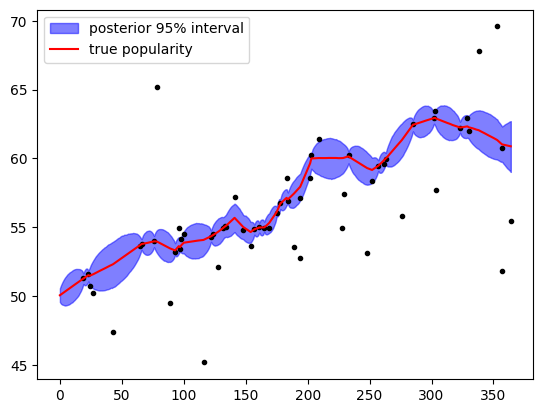

In [94]:
from matplotlib import pyplot as plt

print(z_samples.shape)

plt.plot(observed_times,x_obs,'k.')
plt.fill_between(np.arange(365),
                 np.percentile(z_samples,5,axis=0),
                 np.percentile(z_samples,95,axis=0),
                 color='blue',
                 alpha=0.5,
                 label='posterior 95% interval')
plt.plot(z_samples.mean(0),'r-',label='true popularity')
plt.legend();

# Q10

Create one histogram for samples of $\sigma^\text{trans}$ and another histogram for samples from $\sigma^\text{obs}_1, \cdots, \sigma^\text{obs}_3$ given the observed $x_t$. (Use `bins=100` and `density=True`). Show the resulting histograms only.

To plot the histogram of samples of $\sigma^\text{trans}$, you might want to use code like:

```python
plt.hist(transition_noise_samps,bins=100,density=True);
```

To plot the histogram of samples of $\sigma^\text{obs}_{i}$, you might want to use code like:

```python
plt.hist(observation_noise_samps[:,0],bins=100,density=True,label='pollster 1');
plt.hist(observation_noise_samps[:,1],bins=100,density=True,label='pollster 2');
plt.hist(observation_noise_samps[:,2],bins=100,density=True,label='pollster 3');
plt.legend()
```

You may use one figure for $\sigma^\text{trans}$, and another figure for $\sigma^\text{obs}_{i}$ as long as all the histograms are visible in the same figure. Otherwise, use 4 separate figures.

In [95]:
observation_noise_samps = pg.sample(sig_obs, x, x_obs, niter=10000)
transition_noise_samps = pg.sample(sig_trans, x, x_obs, niter=10000)

NONE
NONE
NONE
NONE
NONE
NONE
NONE
NONE
NONE
NONE
NONE
NONE


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jason\AppData\Local\Temp\ipykernel_1164\4224211539.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Posterior Distributions of $\sigma^{trans}$')


Text(0.5, 1.0, 'Posterior Distributions of $\\sigma^{trans}$')

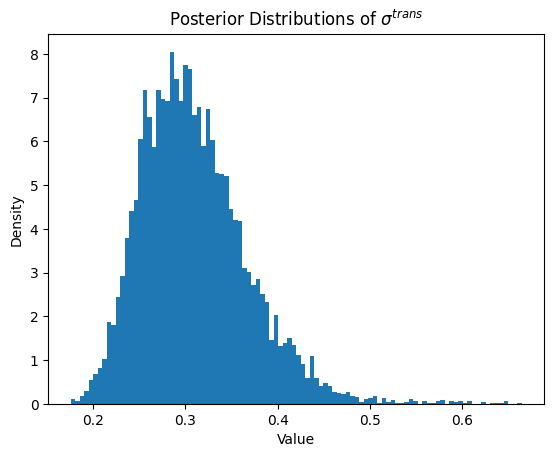

In [87]:
plt.hist(transition_noise_samps,bins=100,density=True);
# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior Distributions of $\sigma^{trans}$')


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jason\AppData\Local\Temp\ipykernel_1164\3920993127.py:7: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Posterior Distributions of $\sigma^{obs}$ for each pollster')


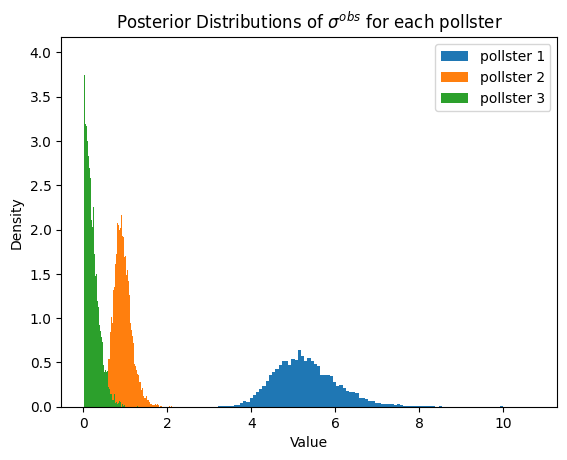

In [89]:
plt.hist(observation_noise_samps[:,0],bins=100,density=True,label='pollster 1');
plt.hist(observation_noise_samps[:,1],bins=100,density=True,label='pollster 2');
plt.hist(observation_noise_samps[:,2],bins=100,density=True,label='pollster 3');
# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior Distributions of $\sigma^{obs}$ for each pollster')

plt.legend()